# Model mismatched entity prediction analysis
In this notebook, we'll dig deeper into why the SciERC model was able to outperform all other models on PICKLE.

The script `evaluate_model_output.py` contains an option, `--save_mismatches`, which is used to generate the output used in this notebook.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})
import jsonlines
from ast import literal_eval
from collections import defaultdict, Counter
from functools import reduce

## Reading in the mismatches

In [3]:
all_models = pd.read_csv('../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/all_but_seedev_on_pickle_test_MISMATCH_MISMATCHES.csv')
seedev = pd.read_csv('../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/seedev_on_pickle_test_MISMATCH_MISMATCHES.csv')
all_models = pd.concat([all_models, seedev])

In [4]:
all_models["model_shorthand"] = all_models["model"].str.split('_').str[-2]
all_models.head()

,doc_key,mismatch_type,sent_num,ent_list,ent_type,model,model_shorthand
0,PMID10549554_abstract,1,0,"[1, 2, 'Biochemical_pathway']",Biochemical_pathway,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
1,PMID10549554_abstract,1,0,"[4, 5, 'Multicellular_organism']",Multicellular_organism,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
2,PMID10549554_abstract,1,0,"[7, 9, 'Biochemical_process']",Biochemical_process,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
3,PMID10549554_abstract,1,0,"[11, 11, 'Biochemical_process']",Biochemical_process,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle
4,PMID10549554_abstract,1,0,"[14, 16, 'Virus']",Virus,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...,pickle


We only want to look at the full SciERC and GENIA models, so let's separate those out:

In [5]:
per_model = {} 
for model in all_models['model_shorthand'].unique():
    df = all_models[all_models['model_shorthand']==model]
    per_model[model] = df

Now, we want to make the same df as the original, excpet with `mismatch_type_GENIA` and `mismatch_type_SciERC` as columns (instead of one `mismatch_type` column and a `moddel` column). We can do this by merging the dataframes with suffixes on columns that differ, and then drop the model columns.

In [6]:
for name, df in per_model.items():
    df = df.drop(columns=['model', 'model_shorthand'])
    per_model[name] = df.rename(columns={'mismatch_type': f'mismatch_type_{name}'})
mismatches = reduce(lambda left, right: pd.merge(left, right, how='inner',
                                    on=['doc_key', 'sent_num', 'ent_list', 'ent_type']), per_model.values())
mismatches.head()

,doc_key,mismatch_type_pickle,sent_num,ent_list,ent_type,mismatch_type_ace05-relation,mismatch_type_scierc,mismatch_type_genia,mismatch_type_chemprot,mismatch_type_scierc-lightweight,mismatch_type_genia-lightweight,mismatch_type_seedev
0,PMID10549554_abstract,1,0,"[1, 2, 'Biochemical_pathway']",Biochemical_pathway,0,0,0,0,1,0,1
1,PMID10549554_abstract,1,0,"[4, 5, 'Multicellular_organism']",Multicellular_organism,0,1,0,0,1,0,1
2,PMID10549554_abstract,1,0,"[7, 9, 'Biochemical_process']",Biochemical_process,0,1,0,0,1,0,1
3,PMID10549554_abstract,1,0,"[11, 11, 'Biochemical_process']",Biochemical_process,0,0,0,0,1,0,0
4,PMID10549554_abstract,1,0,"[14, 16, 'Virus']",Virus,0,1,0,0,1,0,0


## Incorrect predictions by category
First, let's take a look at what percentage of ground truth entities in a given category are predicted correctly by each model.

/mnt/home/lotrecks/anaconda3/envs/pickle/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


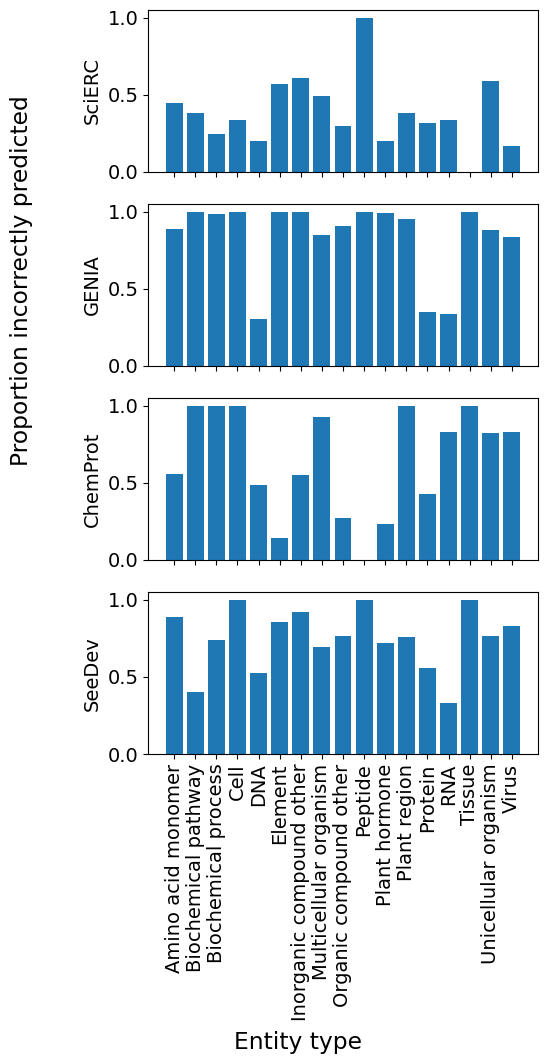

In [7]:
our_models = ['scierc', 'genia', 'chemprot', 'seedev']
model_map = {
    'scierc': 'SciERC',
    'genia': 'GENIA',
    'chemprot': 'ChemProt',
    'seedev': 'SeeDev'
}
type_map = {typ:' '.join(typ.split('_')) for typ in mismatches['ent_type'].unique()}

fig, axs = plt.subplots(4,1, figsize=(6,12), sharex=True)

for ax, mod in zip(axs, our_models):
    prop_incorrect = mismatches.groupby(by='ent_type')[f'mismatch_type_{mod}'].agg(lambda x: x.eq(0).sum()).divide(mismatches['ent_type'].value_counts())
    xlabs = prop_incorrect.index
    ax.bar(prop_incorrect.index, prop_incorrect)
    ax.set_ylabel(model_map[mod])

semantic_xlabs = [type_map[lab] for lab in xlabs]
axs[3].set_xticklabels(semantic_xlabs, rotation=90)
fig.supxlabel('Entity type')
fig.supylabel('Proportion incorrectly predicted', va='bottom')
fig.subplots_adjust(bottom=0.26, left=0.25)
plt.savefig('../data/straying_off_topic_data/corpus_comparison/by_type_barplot.png', format='png', dpi=600)

## Impact of incorrect predictions on overall performance based on category
GENIA performs really poorly in most categories, especially compared to other models. However, its performance on entity extraction on PICKLE isn't substantially different from SeeDev's, which has more categories with a lower proportion of incorrect predictions. This is likely because the categories where GENIA performs well make up a relatively larger proportion of the total of the gold entities wer're trying to predict; we'll quantify this here.

First, let's look at the proportion that each of the types makes up of the gold standard:

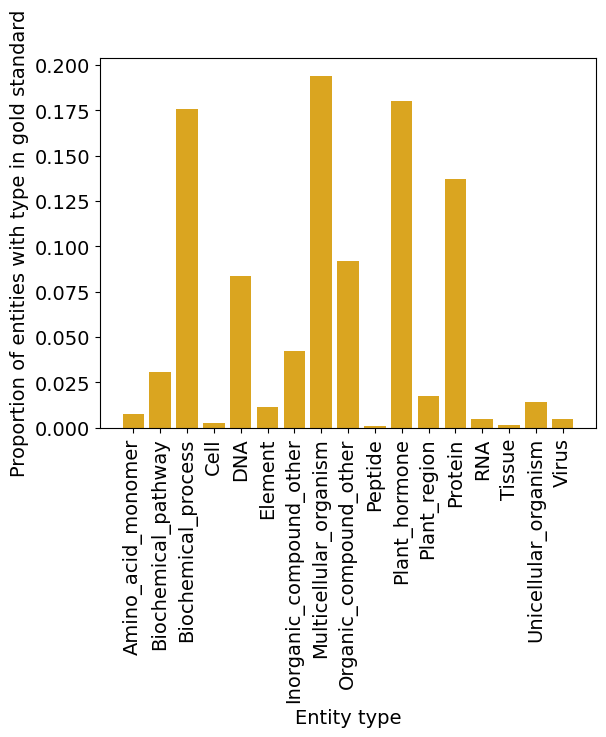

In [15]:
type_gold_props = mismatches.groupby(by='ent_type')['doc_key'].count().divide(mismatches.shape[0])
    
plt.bar(type_gold_props.index, type_gold_props, color='goldenrod')
plt.ylabel('Proportion of entities with type in gold standard')
plt.xlabel('Entity type')
_ = plt.xticks(rotation=90)
plt.savefig('../data/straying_off_topic_data/corpus_comparison/type_proportions_in_gold.png', format='png', dpi=600, bbox_inches='tight')

We now have two pieces of information: the proportion of entities of a given type that were incorrectly predicted by a model, and the proportion of gold standard entities that have that type. Together, these two pieces of information tell us how much an incorrect prediction in a given category influenced the overall performance of a given model on our dataset; if most entities have a given type, and we predict that type wrong, that matters a lot more than predicting incorrectly a type that only appears once or twice in the gold standard. Now, let's take a look at that in a more intuitive way, by defining an **type influence factor**.

We'll define the type influence factor as:

$$(\text{proportion of incorrect predictions for type X})*(\text{proportion of gold standard entities with type X}) \\ for X = \text{Amino acid monomer, Biochemical process...}$$

The higher this number is for a given type, the more incorrect predictions of entities with that type lowered the overall performance of the model.

/mnt/home/lotrecks/anaconda3/envs/pickle/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


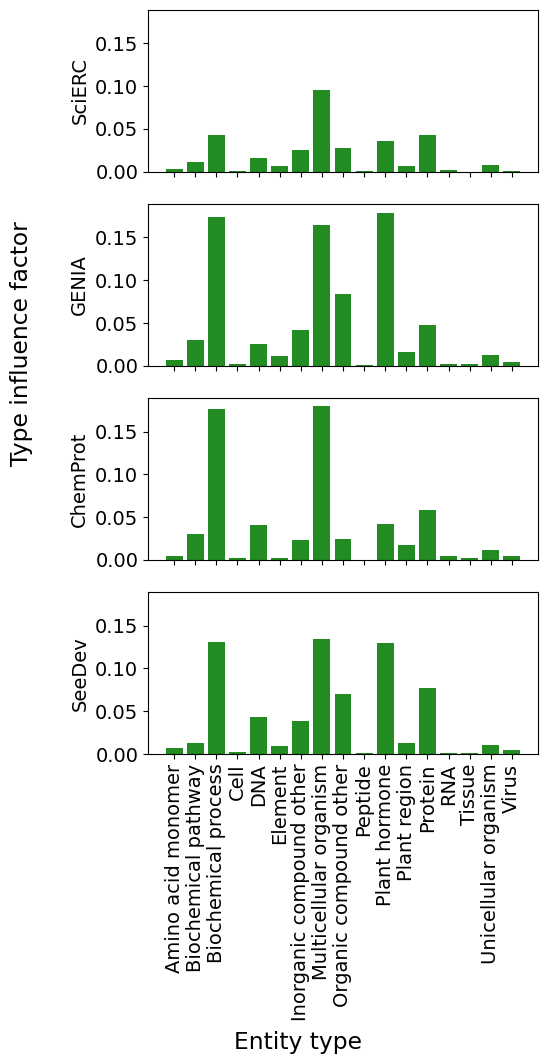

In [11]:
fig, axs = plt.subplots(4,1, figsize=(6,12), sharex=True, sharey=True)

for ax, mod in zip(axs, our_models):
    prop_incorrect = mismatches.groupby(by='ent_type')[f'mismatch_type_{mod}'].agg(lambda x: x.eq(0).sum()).divide(mismatches['ent_type'].value_counts())
    influence_factor = type_gold_props*prop_incorrect
    xlabs = influence_factor.index
    ax.bar(influence_factor.index, influence_factor, color='forestgreen')
    ax.set_ylabel(model_map[mod])

semantic_xlabs = [type_map[lab] for lab in xlabs]
axs[3].set_xticklabels(semantic_xlabs, rotation=90)
fig.supxlabel('Entity type')
fig.supylabel('Type influence factor', va='bottom')
fig.subplots_adjust(bottom=0.26, left=0.25)
plt.savefig('../data/straying_off_topic_data/corpus_comparison/influence_factor_barplot.png', format='png', dpi=600)